# Project for 42186 Model-based Machine Learning F21  

## PGM in Intrusion Detection System

### Notebook - GMM (K=23)

The KDDCUP99 10 percent dataset from the UCI repository. [1] It is a benchmark dataset for the evaluation of network Intrusion Detection System including the records of normal and malicious traffics. It contains 494021 samples in total with 42 dimensions. 

The target for this project is to consider it as a classification problem without time as parameter. This notebook tests a fine-grained detection to classify the data samples into normal or 22 type of attacks by running GMM as an unsupervised learning model to get a intrusion detection result. Based on the model implemented in the GMM (K=2) notebook, this notebook tries to see how this model would perform in 23 clusters.  



\* Note that, due to the GPU timeout issues in Colab, this model is run with local CPU. 

[1] http://kdd.ics.uci.edu/databases/kddcup99/

# **Preparation**

Import required libraries Pyro:

In [ ]:
# Install Pyro, if necessary
!pip install pyro-ppl

Import the necessary packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, TraceEnum_ELBO, JitTrace_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta
from pyro import poutine

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

**Load the dataset from local folder**

Based on the printed statistics and information, the dataset contains 494021 samples in total with 42 dimensions, where the first 41 of them are the features of network traffic and the last dimension is the label to indicate whether the traffic is normal or not. The 41 features are collected by directly extracting from the network traffic flow like the src_bytes, or by computing with a two-second time window like the serror_rate. For these 41 features, they are in the form of continuous, discrete or symbolic with the ranges varying widely. 

In [ ]:
# load csv
data = pd.read_csv("/home/fotonik208/mbml/kddcup.data_10_percent_corrected", header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
duration                       494021 non-null int64
protocol_type                  494021 non-null object
service                        494021 non-null object
flag                           494021 non-null object
src_bytes                      494021 non-null int64
dst_bytes                      494021 non-null int64
land                           494021 non-null int64
wrong_fragment                 494021 non-null int64
urgent                         494021 non-null int64
hot                            494021 non-null int64
num_failed_logins              494021 non-null int64
logged_in                      494021 non-null int64
num_compromised                494021 non-null int64
root_shell                     494021 non-null int64
su_attempted                   494021 non-null int64
num_root                       494021 non-null int64
num_file_creations             494021 

The dataset includes the traffic records with the normal traffics and 22 type of attacks. Among these records, only around 20% of the records are the normal ones and the rest 80% are the abnormal ones.

In [ ]:
proportions = data["type"].value_counts()
print(proportions)
normal_data_count = data["type"].loc[data["type"]=="normal."].value_counts()
print(normal_data_count)
print("Anomaly Percentage", normal_data_count / proportions.sum())

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: type, dtype: int64
normal.    97278
Name: type, dtype: int64
Anomaly Percentage normal.    0.196911
Name: type, dtype: float64


# **Preprocessing**

Data encoding:
The labels are recorded in the format as object. To prepare for the computation afterwards, the categorical labels are encoded into integer numbers. In this case, the normal samples are encoded into 11.   

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data["type"] = ord_enc.fit_transform(data[["type"]])
proportions = data["type"].value_counts()
print(proportions)

18.0    280790
9.0     107201
11.0     97278
0.0       2203
17.0      1589
5.0       1247
15.0      1040
21.0      1020
20.0       979
14.0       264
10.0       231
3.0         53
1.0         30
6.0         21
22.0        20
4.0         12
16.0        10
7.0          9
2.0          8
8.0          7
13.0         4
12.0         3
19.0         2
Name: type, dtype: int64


Since the featrues are saved in different format in the dataset and it's hard to process the features recorded as object. Thus, the one-hot encoding is done to these features to encode them into numerical values. 

In [ ]:
# One-hot encoding the data into numerical values

one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,1,0,0,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,11.0
1,0,1,0,0,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,11.0
2,0,1,0,0,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,11.0
3,0,1,0,0,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,11.0
4,0,1,0,0,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,11.0


Featrue scaling:
 
Considering the features has different range, standardization is done to deal with this by keeping the values centered around the mean with a unit standard deviation.

In [ ]:
# Standardize the numeric variables

cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

Split the dataset:

Split the label out of the dataset into X and y. Split the X and y into trainset and testset with 66% of samples as trainset.

In [ ]:
# separate between features/inputs X and label/output variables y
mat = data.values
X = mat[:,0:-1]
print(X.shape)
y = mat[:,-1]
y = y.astype('int')
print(y.shape)


(494021, 118)
(494021,)


In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 326053
num test: 167968


# **Baseline model from sklearn**

Define the GMM from sklearn as the baseline model:

In [ ]:
# create and fit logistic regression model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=23, random_state=42).fit(X_train)
y_hat = gmm.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [3 0 0 ... 0 7 1]
true values: [ 9 18 18 ... 18 11  9]
Accuracy: 0.0017265193370165745


To look into details on how the model performs, classification_report provided by sklearn is called here to present a detailed evaluation with metrics like precision, recall, f1-score for each class. This baseline model shows very poor detection capability with only a few samples properly labeled. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       778
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00       438
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.36      0.01      0.02     36339
          10       0.00      0.00      0.00        78
          11       0.00      0.00      0.00     33238
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        92
          15       0.01      0.01      0.01       355
          16       0.00      0.00      0.00         3
          17       0.00    

/home/fotonik208/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fotonik208/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **GMM Model Training & Evaluation**

**GMM model with 23 components**

In this notebook, based on the model in notebook GMM (K=2), the model is modified with 23 components (K=23) and tuned to make the clustering for the samples. The generative process is still like: 



1. Draw $w$ which is a vector $(1 \times K)$ with probabilities of each class: $w \sim \operatorname{Dirichlet}\left(w_{0}=10\right)$
2. Draw the uncertainty value of the clusters: $\sigma \sim \operatorname{Lognormal}\left(\mu_{0}=0, \sigma_{0}=20\right)$
3. For each cluster $k$ in the clusters $k \in\{1, \ldots, K\}$ where $K=23$: 
  * Draw the mean value of the this cluster: $\mu_{k} \sim \operatorname{Normal}\left(\mu_{1}=0, \sigma_{1}=20\right)$

4. For each sample in the dataset $n \in\{1, \ldots, N\}$: 
  * Draw latent variable: $z_{n} \sim \operatorname{Cat}(w)$ 
  * Define $k=z_{n}$ generate the samples: $x_{n} \sim \operatorname{Normal}\left(\mu_{k}, \sigma\right)$

To implement the model, vectorization is done for the variable to optimize the performance in Pyro. This implementation refers to the Pyro guideline [2] and config_enumerate() handler in Pyro [3] is called here to enable the enumeration over the assignments in each iteration.

[2] Gaussian Mixture Model, https://pyro.ai/examples/gmm.html


[3] Inference with Discrete Latent Variables, http://pyro.ai/examples/enumeration.html

In [ ]:
K = 23  # Fixed number of components.

@config_enumerate
def gmm(data):
    D = data.shape[1]
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(10 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 20.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(torch.zeros(D), 20.).to_event(1))
        assert locs.shape == (K, D)
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale).to_event(1), obs=data)

The speed of the learning process is tweaked by defining the learning rate and $\beta_{1}$ & $\beta_{2}$. To run the inference in Pyro, TraceEnum_ELBO is used here to enable the enumerations in parallel during the sampling from discrete latent states. 

In [ ]:
optim = pyro.optim.Adam({'lr': 0.0001, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
# transform the dataset to tensor
X_train_torch = torch.tensor(X_train).float()
X_test_torch = torch.tensor(X_test).float()

The auto guide AutoDelta is used to construct a MAP guide based on Delta distributions. SVI is configured for inference. Initialization is done first in the consideration of the GMM is prone to local mode. The optimal initail value is selected from a number of values by iterating the seeds. 

In [ ]:
# Initialize weights to uniform.
def init_loc_fn(site):
    if site["name"] == "weights":
        return torch.ones(K) / K
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(gmm, expose=['weights', 'locs', 'scale']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(gmm, global_guide, optim, loss=elbo)
    return svi.loss(gmm, global_guide, data)

# Choose the best among 1000 random initializations.
data = X_train_torch
loss, seed = min((initialize(seed), seed) for seed in range(1000))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 709, initial_loss = 14866645.0


The inference comletes after 10000 steps. The plot below presents that the loss basically approaches the convergence but would be better to keep it running for more steps.

In [ ]:
losses = []
n_steps = 10000
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, loss))

/home/fotonik208/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


[0] ELBO: 14866645.0
[500] ELBO: 14483098.0
[1000] ELBO: 14251978.0
[1500] ELBO: 14120501.0
[2000] ELBO: 14013857.0
[2500] ELBO: 13916072.0
[3000] ELBO: 13826027.0
[3500] ELBO: 13741183.0
[4000] ELBO: 13660257.0
[4500] ELBO: 13587161.0
[5000] ELBO: 13514713.0
[5500] ELBO: 13452824.0
[6000] ELBO: 13392528.0
[6500] ELBO: 13328294.0
[7000] ELBO: 13274397.0
[7500] ELBO: 13221549.0
[8000] ELBO: 13168708.0
[8500] ELBO: 13121158.0
[9000] ELBO: 13072682.0
[9500] ELBO: 13028514.0


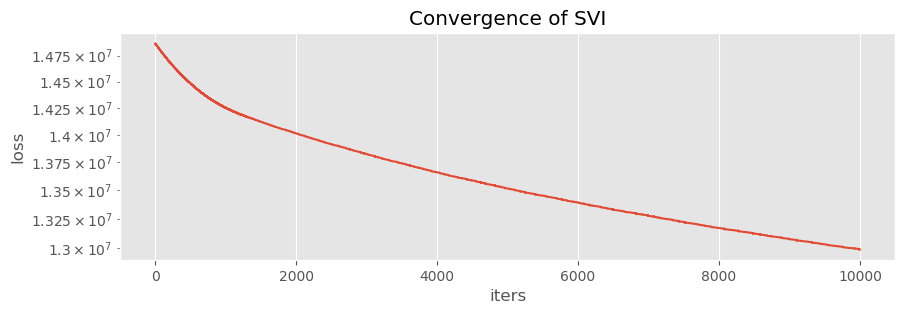

In [ ]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

**Model evaluation**

With a model trained by the trainset, the model is expected to be used to make prediction on the testset for evaluation. To do this, the classifier is built to predict the testset based on the discrete inference. Effect handlers of *trace*, *replay* and *infer_discrete* in Pyro is used here to build the classfier and read out the cluster assignment results from the model. The trace hanlder here records the relationships amongst different pyro primitives. Each node in the trace includes the name, input and output value of the site. [4]


[4] Trace, https://docs.pyro.ai/en/dev/poutine.html#trace

In [ ]:
guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
trained_model = poutine.replay(gmm, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature, first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    print(trace)
    return trace.nodes["assignment"]["value"], trace.nodes["weights"]["value"], trace.nodes["locs"]["value"], trace.nodes["scale"]["value"]

print(classifier(X_test_torch))

(tensor([13,  4,  4,  ...,  4, 18, 17]), tensor([0.0194, 0.0348, 0.0120, 0.0217, 0.0861, 0.0120, 0.0120, 0.0861, 0.0861,
        0.0861, 0.0762, 0.0576, 0.0118, 0.0462, 0.0349, 0.0349, 0.0120, 0.0349,
        0.0162, 0.0349, 0.0861, 0.0861, 0.0120], grad_fn=<ExpandBackward>), tensor([[ 6.5452e-02,  8.3557e-01,  9.8977e-02,  ..., -4.5570e-01,
         -1.8447e-01, -2.2551e-01],
        [-8.3179e-06,  1.0000e+00,  9.9270e-06,  ...,  2.1615e+00,
         -2.5202e-01, -2.4942e-01],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ..., -4.6248e-01,
          4.0472e+00,  3.9719e+00],
        ...,
        [ 9.9987e-01,  5.5191e-07,  1.3197e-04,  ..., -4.6320e-01,
         -2.5196e-01, -2.4946e-01],
        [ 9.9987e-01,  5.5191e-07,  1.3197e-04,  ..., -4.6320e-01,
         -2.5196e-01, -2.4946e-01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ..., -4.6320e-01,
          1.6149e+00, -2.4946e-01]], grad_fn=<ExpandBackward>), tensor(0.3348, grad_fn=<ExpandBackward>))


In [ ]:
y_pred, y_weights, y_locs, y_scale = classifier(X_test_torch)
print(y_pred)

tensor([13,  4,  4,  ...,  4, 18, 17])


**Prediction results**

Detach the prediction results and make a general evalution on the accuracy by comparing the labels between the testset and prediction results. 

The accuracy shows an accuracy of 0.05 which is a bit higher than the baseline result 0.01 got from sklearn. But since there are too many components in the mixture model, so it is hard to expect this simple model to reach a fairly high accuracy. 

In [ ]:
y_pred = y_pred.detach().cpu().numpy() 
# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_pred == y_test) / len(y_test))

Accuracy: 0.05887430939226519


By taking a closer look at the prediction results for each cluster, the model implemented in Pyro also shows a slightly better performance than the sklearn baseline model in general. Specifically, the model shows a detection capability over the normal samples (encoded as 11), but the detection on a specific attack is still very poor. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/home/fotonik208/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fotonik208/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      0.19      0.07       778
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00       438
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00     36339
          10       0.00      0.05      0.00        78
          11       1.00      0.29      0.45     33238
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        92
          15       0.00      0.00      0.00       355
          16       0.00      0.00      0.00         3
          17       0.00    

**Clustering parameters**

Below presents the parameters fitted for the GMM model trained in Pyro. When there are quite a number of components in GMM, each of the components can only get a small share or weights. 

In [ ]:
y_weights.cpu().detach().numpy()

array([0.01937251, 0.03483991, 0.01203551, 0.02171712, 0.08606572,
       0.01199677, 0.01204915, 0.08606572, 0.08606572, 0.08606572,
       0.07622287, 0.05755595, 0.0118488 , 0.04623242, 0.03487562,
       0.03488879, 0.01201984, 0.03488914, 0.01619892, 0.03486079,
       0.08606572, 0.08606572, 0.01200161], dtype=float32)

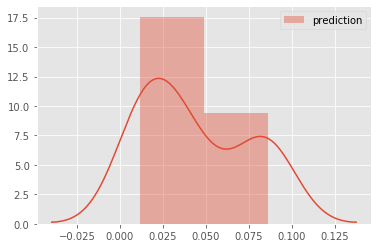

In [ ]:
sns.distplot(y_weights.cpu().detach().numpy(), label="prediction")
plt.legend()
plt.show()

To clearly compare the mixture model, the density estimate and histogram is drawn for both the real case (blue) and predicted case (red). In general, they have some overlaps but the predictions have a quite large deviation from the real case, which need an improved and well-tuned model for better fits. 

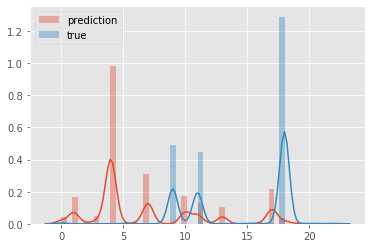

In [ ]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_test, label="true")
plt.legend()
plt.show()